In [ ]:
!pip install torch torchvision torchaudio
!pip install pytorch3d
!pip install open3d
!pip install tqdm matplotlib numpy scikit-learn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

In [ ]:
def load_point_clouds(path, num_points=1024):
    point_clouds = []
    for _ in range(1000):
        theta = np.random.rand(num_points) * 2 * np.pi
        phi = np.random.rand(num_points) * np.pi
        x = np.sin(phi) * np.cos(theta)
        y = np.sin(phi) * np.sin(theta)
        z = np.cos(phi)
        points = np.stack([x, y, z], axis=1)
        point_clouds.append(points)
    return torch.tensor(point_clouds).float()

pc_data = load_point_clouds("modelnet/", num_points=1024)
print("Loaded point cloud shape:", pc_data.shape)

Loaded point cloud shape: torch.Size([1000, 1024, 3])


/tmp/ipython-input-3-538467865.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(point_clouds).float()


In [ ]:
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

T = 1000  # Total diffusion steps
betas = linear_beta_schedule(T)
alphas = 1.0 - betas
alpha_hat = torch.cumprod(alphas, dim=0)

def forward_diffusion(x_0, t):
    noise = torch.randn_like(x_0)
    # Reshape to (batch_size, 1, 1) for broadcasting
    sqrt_alpha_hat = alpha_hat[t].view(-1, 1, 1).to(x_0.device) ** 0.5
    sqrt_one_minus_alpha_hat = (1 - alpha_hat[t]).view(-1, 1, 1).to(x_0.device) ** 0.5
    return sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise, noise


In [ ]:
class PointNet(nn.Module):
    def __init__(self, point_dim=3):
        super(PointNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(point_dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, point_dim)
        )

    def forward(self, x, t):
        t_embed = t.unsqueeze(1).repeat(1, x.shape[1], 1) / T
        x_input = torch.cat([x, t_embed], dim=-1)
        return self.mlp(x_input)

model = PointNet()


In [ ]:
def compute_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion(x_0, t)
    noise_pred = model(x_noisy, t.unsqueeze(-1).float())
    return F.mse_loss(noise_pred, noise)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 20
batch_size = 16

for epoch in range(epochs):
    perm = torch.randperm(pc_data.size(0))
    losses = []
    for i in range(0, len(perm), batch_size):
        idx = perm[i:i+batch_size]
        x_0 = pc_data[idx]
        t = torch.randint(0, T, (x_0.shape[0],), device=x_0.device)
        loss = compute_loss(model, x_0, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")

Epoch 1/20, Loss: 0.8716
Epoch 2/20, Loss: 0.6401
Epoch 3/20, Loss: 0.4451
Epoch 4/20, Loss: 0.2870
Epoch 5/20, Loss: 0.2298
Epoch 6/20, Loss: 0.2114
Epoch 7/20, Loss: 0.2170
Epoch 8/20, Loss: 0.2192
Epoch 9/20, Loss: 0.2117
Epoch 10/20, Loss: 0.2109
Epoch 11/20, Loss: 0.2144
Epoch 12/20, Loss: 0.1937
Epoch 13/20, Loss: 0.1974
Epoch 14/20, Loss: 0.1732
Epoch 15/20, Loss: 0.1836
Epoch 16/20, Loss: 0.2063
Epoch 17/20, Loss: 0.1845
Epoch 18/20, Loss: 0.2063
Epoch 19/20, Loss: 0.1911
Epoch 20/20, Loss: 0.2032


[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


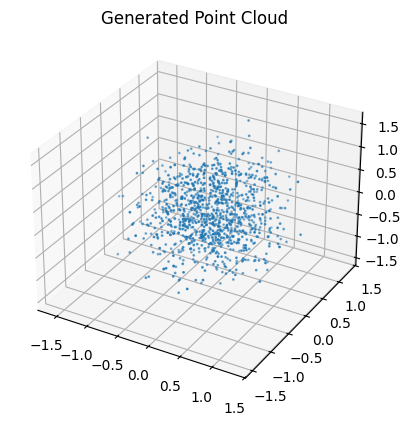

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

@torch.no_grad()
def sample(model, num_points=1024):
    x_t = torch.randn((1, num_points, 3))
    for t in reversed(range(T)):
        t_tensor = torch.full((1,), t, dtype=torch.float32)
        predicted_noise = model(x_t, t_tensor.unsqueeze(-1))
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_hat_t = alpha_hat[t]
        if t > 0:
            noise = torch.randn_like(x_t)           # lol, I'm so funny.
        else:
            noise = 0
        x_t = (1 / alpha_t**0.5) * (x_t - (1 - alpha_t) / (1 - alpha_hat_t)**0.5 * predicted_noise) + beta_t**0.5 * noise
    return x_t

sampled_shape = sample(model).squeeze().numpy()
o3d.visualization.draw_geometries([o3d.geometry.PointCloud(o3d.utility.Vector3dVector(sampled_shape))])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sampled_shape[:, 0], sampled_shape[:, 1], sampled_shape[:, 2], s=1)
ax.set_title("Generated Point Cloud")
plt.show()


In [ ]:
def chamfer_distance(p1, p2):
    d1 = pairwise_distances(p1, p2).min(axis=1).mean()
    d2 = pairwise_distances(p2, p1).min(axis=1).mean()
    return d1 + d2

generated = sample(model).squeeze().numpy()
real = pc_data[0].numpy()
print("Chamfer Distance:", chamfer_distance(real, generated))

Chamfer Distance: 0.43468213
